In [ ]:
!pip install "dask>=2025.10.0" "geopandas>=1.1.1" "h5netcdf>=1.6.4" "ipykernel>=6.30.1" "matplotlib>=3.10.6" "rasterio>=1.4.3" "rioxarray>=0.19.0" "xarray>=2025.9.0" --upgrade

In [1]:
from google.colab import drive
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)
CORE_PATH = '/content/drive/My Drive/babe/GenHack'

Mounted at /content/drive


### 1. Admin Boundaries

In [18]:
# Load data
gadm_path = os.path.join(CORE_PATH, 'gadm_410_europe.gpkg')
gadm_gdf = gpd.read_file(gadm_path) if os.path.exists(gadm_path) else None

In [19]:
# print(gadm_europe.head(5))
print(gadm_gdf.columns)
'''
The level seems to be country-region-department-district-canton
'''

country_code = "FRA" # France
cityname = "Paris"

region_name = "Île-de-France"

filtered_gadm_gdf = gadm_gdf[
    (gadm_gdf.GID_0 == country_code) &
    (gadm_gdf.NAME_1 == region_name)
]


# gadm_europe[(gadm_europe['NAME_0'] == 'France') & (gadm_europe['NAME_1'] == 'Île-de-France') & (gadm_europe['NAME_2'] == 'Paris')]

one_city_gdf = filtered_gadm_gdf.dissolve()
one_city_gdf.head()
one_city_gdf

Index(['UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'ENGTYPE_1', 'GID_2',
       'NAME_2', 'ENGTYPE_2', 'GID_3', 'NAME_3', 'ENGTYPE_3', 'GID_4',
       'NAME_4', 'ENGTYPE_4', 'GID_5', 'NAME_5', 'ENGTYPE_5', 'COUNTRY',
       'CONTINENT', 'geometry'],
      dtype='object')


,geometry,UID,GID_0,NAME_0,GID_1,NAME_1,ENGTYPE_1,GID_2,NAME_2,ENGTYPE_2,...,NAME_3,ENGTYPE_3,GID_4,NAME_4,ENGTYPE_4,GID_5,NAME_5,ENGTYPE_5,COUNTRY,CONTINENT
0,"POLYGON ((1.65691 48.62809, 1.64957 48.63227, ...",76158,FRA,France,FRA.8_1,Île-de-France,Region,FRA.8.1_1,Essonne,Department,...,Étampes,Districts,FRA.8.1.1.1_1,Dourdan,Canton,FRA.8.1.1.1.1_1,Authon-la-Plaine,Commune,France,Europe


<Axes: >

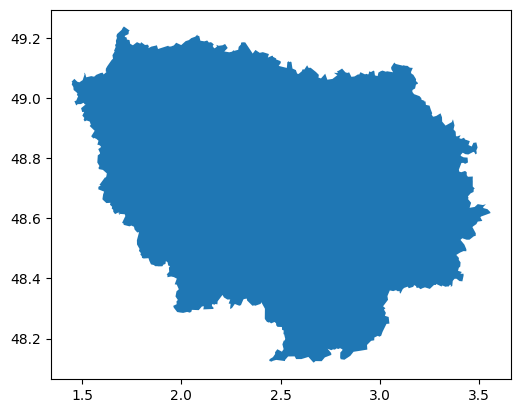

In [ ]:
one_city_gdf.plot()


### 2.Meteo: temperature, percipitation and wind

In [20]:
!pip install cftime --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00


In [21]:
meteo_path = os.path.join(CORE_PATH, 'derived-era5-land-daily-statistics')
meteo_files = [f for f in os.listdir(meteo_path) if f.endswith('.nc')] if os.path.exists(meteo_path) else []

In [22]:
import xarray as xr
import os
import pandas as pd
import numpy as np

# Assume meteo_path, meteo_files, one_city_gdf are defined

def tempData():
    tnames = '2020_2m_temperature_daily_maximum.nc'
    years = [2020, 2021, 2022, 2023, 2024, 2025]

    file_paths = []
    for year in years:
        file_name = tnames.replace('2020', str(year))
        if file_name in meteo_files:
            file_paths.append(os.path.join(meteo_path, file_name))

    if not file_paths:
        print("No temperature files found.")
        return pd.DataFrame()

    try:
        # 1. Open datasets.
        # using combine='by_coords' is often safer for 'valid_time' structures
        ds = xr.open_mfdataset(file_paths, combine='by_coords')

        # 2. Identify the correct time coordinate name
        # The screenshot shows 'valid_time', but we check both just in case.
        time_coord = 'time'
        if 'valid_time' in ds.coords:
            time_coord = 'valid_time'

        print(f"DEBUG: Detected time coordinate: '{time_coord}'")

        # 3. Clip to Île-de-France
        minx, miny, maxx, maxy = one_city_gdf.geometry.iloc[0].bounds
        clipped_ds = ds.sel(latitude=slice(maxy, miny), longitude=slice(minx, maxx))

        # 4. Check if we need to rename the variable
        # Your screenshot showed 'u10' (wind), but your file name says 'temperature'.
        # We assume 't2m' is the target, but we'll print available vars if missing.
        target_var = 't2m'
        if target_var not in clipped_ds:
            # Fallback for common aliases if t2m isn't found
            if 'tx' in clipped_ds: target_var = 'tx'
            elif 'mx2t' in clipped_ds: target_var = 'mx2t'
            else:
                print(f"ERROR: Variable '{target_var}' not found. Available: {list(clipped_ds.data_vars)}")
                return pd.DataFrame()

        # 5. Convert to DataFrame
        temp_df = clipped_ds[target_var].to_dataframe().reset_index()

        # 6. Rename the detected time column to standard 'DATE_full'
        temp_df = temp_df.rename(columns={target_var: 'MAX_TEMP_K', time_coord: 'DATE_full'})

        # 7. Ensure DATE_full is datetime
        # Since the screenshot showed datetime64[ns], this is likely just a pass-through,
        # but it fixes cases where it might be an object.
        if not pd.api.types.is_datetime64_any_dtype(temp_df['DATE_full']):
             temp_df['DATE_full'] = pd.to_datetime(temp_df['DATE_full'])

        # 8. Calculate Celsius
        temp_df['MAX_TEMP_C'] = (temp_df['MAX_TEMP_K'] - 273.15).round(2)

        # 9. Create YYYYMMDD integer
        temp_df['DATE'] = temp_df['DATE_full'].dt.strftime('%Y%m%d').astype(int)

        # Cleanup
        final_cols = ['DATE', 'latitude', 'longitude', 'MAX_TEMP_C']
        temp_df = temp_df[final_cols]

        return temp_df

    except Exception as e:
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# Run it
gridded_temp_df = tempData()
print(f"Total records: {len(gridded_temp_df)}")
if not gridded_temp_df.empty:
    print(gridded_temp_df.head())

DEBUG: Detected time coordinate: 'valid_time'
Total records: 484638
       DATE  latitude  longitude  MAX_TEMP_C
0  20200101      49.2        1.5        5.90
1  20200101      49.2        1.6        5.78
2  20200101      49.2        1.7        5.66
3  20200101      49.2        1.8        5.49
4  20200101      49.2        1.9        5.31


In [24]:
gridded_temp_df #hourly
df_daily = gridded_temp_df.groupby('DATE').agg({'MAX_TEMP_C': 'max'}).reset_index()
df_daily

,DATE,MAX_TEMP_C
0,20200101,7.16
1,20200102,9.02
2,20200103,11.15
3,20200104,8.58
4,20200105,8.61
...,...,...
2093,20250924,12.37
2094,20250925,13.06
2095,20250926,15.12
2096,20250927,15.90


In [ ]:
'''
U wind: zional, eastward and westward winds
V wind: meridional, northen and southern winds
'''
years = [2020, 2021, 2022, 2023, 2024, 2025]
w_unames = '2020_10m_u_component_of_wind_daily_mean.nc'
w_vnames = '2020_10m_v_component_of_wind_daily_mean.nc'
def windData():
  for year in years:
    w_uname = w_unames.replace('2020', str(year))
    w_vname = w_vnames.replace('2020', str(year))
    if w_uname in meteo_files and w_vname in meteo_files:
      xr.open_dataset(os.path.join(meteo_path, w_uname))
      xr.open_dataset(os.path.join(meteo_path, w_vname))
      #刚刚到这儿
  return

In [ ]:
def percipitationData():

  return

In [ ]:
meteo_da = None
data_unit = 'm s⁻¹'  # Default unit if extraction fails

# 1. Load data and fix metadata
target_file = '2021_10m_v_component_of_wind_daily_mean.nc'
if target_file in meteo_files:
    # Load DataArray with time decoding
    meteo_da = rxr.open_rasterio(os.path.join(meteo_path, target_file), decode_times=True)
    print(f"Loaded file: {target_file}")
    print(f"Variable name: {meteo_da.name}")

    # Fix repeated units (extract first element from list/tuple)
    if 'units' in meteo_da.attrs and isinstance(meteo_da.attrs['units'], (list, tuple)):
        data_unit = meteo_da.attrs['units'][0]
    print(f"Data unit: {data_unit}")

Loaded file: 2021_10m_v_component_of_wind_daily_mean.nc
Variable name: v10
Data unit: m s**-1


In [ ]:
from cftime import DatetimeProlepticGregorian

# Time filtering (Summer 2021: Jun-Aug) - Stable time handling
temporal_dim = 'valid_time'
time_vals = meteo_da[temporal_dim].values

# Convert cftime to string -> pandas datetime (handles all cases)
if isinstance(time_vals[0], DatetimeProlepticGregorian):
    time_str = [str(t) for t in time_vals]
    meteo_da[temporal_dim] = pd.to_datetime(time_str)
else:
    meteo_da[temporal_dim] = pd.to_datetime(time_vals)

meteo_filtered = meteo_da.sel({temporal_dim: slice('2021-06-01', '2021-08-31')})

# Validate filtered data and compute mean (Stable date formatting)
if meteo_filtered.sizes[temporal_dim] > 0:
    start_date = pd.to_datetime(meteo_filtered[temporal_dim].min().item()).strftime('%Y-%m-%d')
    end_date = pd.to_datetime(meteo_filtered[temporal_dim].max().item()).strftime('%Y-%m-%d')
    print(f"Filtered time range: {start_date} to {end_date} ({meteo_filtered.sizes[temporal_dim]} days)")
    wind_mean = meteo_filtered.mean(dim=temporal_dim, skipna=True)
else:
    start_date = pd.to_datetime(meteo_da[temporal_dim].min().item()).strftime('%Y-%m-%d')
    end_date = pd.to_datetime(meteo_da[temporal_dim].max().item()).strftime('%Y-%m-%d')
    print(f"No data in selected time range. Using full 2021 dataset ({start_date} to {end_date}).")
    wind_mean = meteo_da.mean(dim=temporal_dim, skipna=True)

Filtered time range: 2021-06-01 to 2021-08-31 (92 days)


### 3. Vegetation

In [ ]:
from google.colab import drive
import os
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)
CORE_PATH = '/content/drive/My Drive/babe/GenHack'

Mounted at /content/drive


In [ ]:
# Load data + convert to real scale
ndvi_path = os.path.join(CORE_PATH, 'sentinel2_ndvi')
ndvi_files = [f for f in os.listdir(ndvi_path) if f.endswith('.tif')] if os.path.exists(ndvi_path) else []

Original int8 value range: 2.0 to 255.0
Number of non-255 pixels: 48844934 / 49000000

Loaded NDVI file: ndvi_2019-12-01_2020-03-01.tif
Optimized data shape: (7000, 7000) (original full size: 52389×61776)
NDVI value range: -0.98 to 0.98
NDVI filtered: Vegetated areas (NDVI > 0.3)


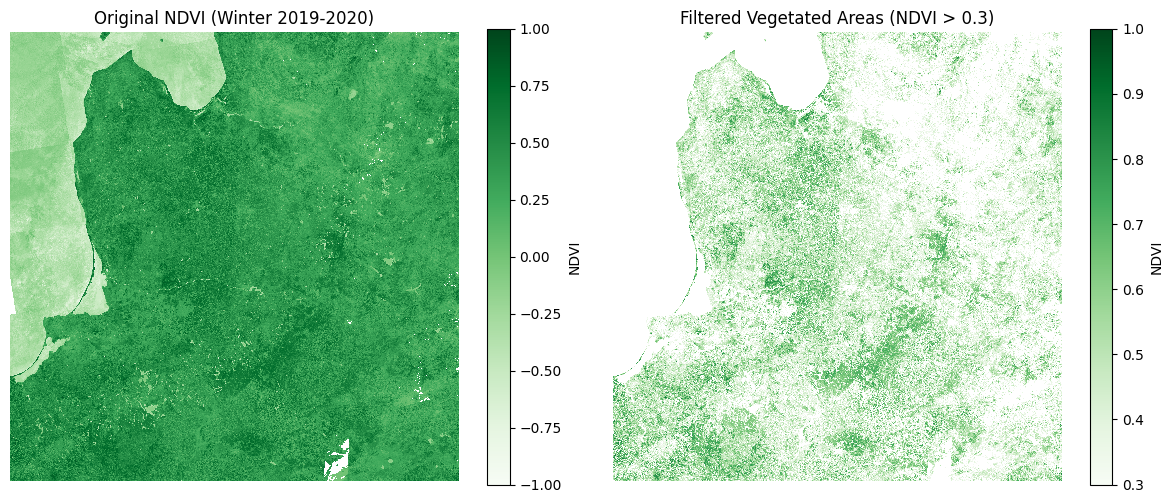


NDVI Statistical Summary:
Minimum NDVI: -0.98
Maximum NDVI: 0.98
Mean NDVI: 0.29
Percentage of Vegetated Areas (NDVI > 0.3): 58.7%


In [ ]:
ndvi_real = None

target_ndvi_file = ndvi_files[0]
with rasterio.open(os.path.join(ndvi_path, target_ndvi_file)) as src:
    window = rasterio.windows.Window.from_slices((20000, 27000), (30000, 37000))
    ndvi_int8 = src.read(1, window=window)
    ndvi_int8 = ndvi_int8.astype(np.float32)

    print(f"Original int8 value range: {np.min(ndvi_int8)} to {np.max(ndvi_int8)}")
    print(f"Number of non-255 pixels: {np.sum(ndvi_int8 != 255)} / {ndvi_int8.size}")

# Convert to real NDVI (-1 to 1)
ndvi_real = np.where(ndvi_int8 == 255, np.nan, (ndvi_int8 / 127) - 1)

valid_ndvi = ndvi_real[~np.isnan(ndvi_real)]
if len(valid_ndvi) > 0:
    print(f"\nLoaded NDVI file: {target_ndvi_file}")
    print(f"Optimized data shape: {ndvi_real.shape} (original full size: {src.height}×{src.width})")
    print(f"NDVI value range: {np.nanmin(ndvi_real):.2f} to {np.nanmax(ndvi_real):.2f}")
else:
    print(f"\nWarning: No valid NDVI data in current window!")
    print("Try adjusting the window range (e.g., (22000,24000), (28000,30000))")

# Filter: Vegetated areas (NDVI > 0.3)
if ndvi_real is not None and len(ndvi_real[~np.isnan(ndvi_real)]) > 0:
    ndvi_vegetated = np.where(ndvi_real > 0.3, ndvi_real, np.nan)
    print(f"NDVI filtered: Vegetated areas (NDVI > 0.3)")
else:
    ndvi_vegetated = None

# Visualization
if ndvi_real is not None and len(ndvi_real[~np.isnan(ndvi_real)]) > 0:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ndvi_real, cmap='Greens', vmin=-1, vmax=1, interpolation='none')
    plt.title('Original NDVI (Winter 2019-2020)')
    plt.axis('off')
    plt.colorbar(label='NDVI', shrink=0.8)

    plt.subplot(1, 2, 2)
    plt.imshow(ndvi_vegetated, cmap='Greens', vmin=0.3, vmax=1, interpolation='none')
    plt.title('Filtered Vegetated Areas (NDVI > 0.3)')
    plt.axis('off')
    plt.colorbar(label='NDVI', shrink=0.8)

    plt.tight_layout()
    plt.show()

    print(f"\nNDVI Statistical Summary:")
    print(f"Minimum NDVI: {np.nanmin(ndvi_real):.2f}")
    print(f"Maximum NDVI: {np.nanmax(ndvi_real):.2f}")
    print(f"Mean NDVI: {np.nanmean(ndvi_real):.2f}")
    vegetated_pct = (np.sum(ndvi_vegetated > 0.3) / np.sum(~np.isnan(ndvi_real))) * 100
    print(f"Percentage of Vegetated Areas (NDVI > 0.3): {vegetated_pct:.1f}%")
elif ndvi_real is not None:
    print("No valid NDVI data to visualize. Please adjust the window range.")


### 4. Weather Stations

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np

CORE_PATH = '/content/drive/My Drive/babe/GenHack'
weather_zip = os.path.join(CORE_PATH, 'ECA_blend_tx.zip')
extract_dir = os.path.join(CORE_PATH, 'ECA_blend_tx') # Changed directory name as requested

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(weather_zip, 'r') as zf:
        zf.extractall(extract_dir)
    print(f"Unzipped files to: {extract_dir}")
else:
    print("Extract directory already exists, skip unzipping")

Unzipped files to: /content/drive/My Drive/babe/GenHack/ECA_blend_tx


In [ ]:
print("Unique country codes in stations_gdf:\n", stations_gdf['CN'].unique())

Unique country codes in stations_gdf:
 ['SE  ' 'AT  ' 'HR  ' 'CY  ' 'CZ  ' 'FI  ' 'FR  ' 'DE  ' 'GR  ' 'HU  '
 'IS  ' 'RU  ' 'DK  ' 'IE  ' 'IL  ' 'NL  ' 'IT  ' 'NO  ' 'LV  ' 'LT  '
 'LU  ' 'PL  ' 'PT  ' 'RO  ' 'SK  ' 'SI  ' 'ES  ' 'CH  ' 'TR  ' 'UA  '
 'GB  ' 'RS  ' 'EE  ' 'BA  ' 'AL  ' 'DZ  ' 'AM  ' 'GL  ' 'EG  ' 'TM  '
 'KZ  ' 'AZ  ' 'MD  ' 'MT  ' 'BY  ' 'BG  ' 'MA  ' 'TN  ' 'IR  ' 'IQ  '
 'LY  ' 'MK  ' 'SY  ' 'UZ  ' 'KG  ' 'SA  ' 'TJ  ' 'LB  ' 'ME  ' 'SJ  '
 'BE  ']


Filter Weather Stations

In [2]:
eca_tx_datafolder = CORE_PATH + "/ECA_blend_tx/"
stations_filepath = eca_tx_datafolder + "stations.txt"
# stations_filepath = '/content/drive/My Drive/babe/GenHack/combined_cleaned_weather_data.csv'

In [3]:
def dms_to_decimal(dms_str):
    # This function converts a DMS (Degrees:Minutes:Seconds) string to decimal degrees.
    dms_str = dms_str.strip()

    sign = 1 if dms_str[0] == '+' else -1

    dms_str = dms_str[1:]

    parts = dms_str.split(':')
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])

    decimal = sign * (degrees + minutes/60 + seconds/3600)

    return decimal

In [16]:
stations_df = pd.read_csv(
    stations_filepath,
    skiprows=17,
    skipinitialspace=True
)

stations_df['LAT_decimal'] = stations_df['LAT'].apply(dms_to_decimal)
stations_df['LON_decimal'] = stations_df['LON'].apply(dms_to_decimal)

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['LON_decimal'], stations_df['LAT_decimal']),
    crs="EPSG:4326" # (WGS84, adequate for lat/lon coordinates)
).drop(columns=['LAT', 'LON', 'LAT_decimal', 'LON_decimal'])

print(f"Number of registered stations: {len(stations_gdf)}")
# stations_gdf.head()
stations_gdf

Number of registered stations: 8568


,STAID,STANAME,CN,HGHT,geometry
0,1,VAEXJOE,SE,166,POINT (14.8 56.86667)
1,2,FALUN,SE,160,POINT (15.61667 60.61667)
2,3,STENSELE,SE,325,POINT (17.16639 65.06667)
3,4,LINKOEPING,SE,93,POINT (15.53306 58.4)
4,5,LINKOEPING-MALMSLAETT,SE,93,POINT (15.53306 58.4)
...,...,...,...,...,...
8563,28070,TRAPANI FONTANASALSA,IT,57,POINT (12.5525 37.94167)
8564,28071,TRAPANI FULGATORE,IT,190,POINT (12.66139 37.9475)
8565,28072,DUGURDSKAMPEN BH3,NO,1546,POINT (8.38583 61.69667)
8566,28075,CANTONIGROS,ES,925,POINT (2.40444 42.0425)


In [10]:
france_stations_gdf = stations_gdf[stations_gdf['CN'].str.strip() == 'FR']
print(f"Number of stations in France: {len(france_stations_gdf)}")
france_stations_gdf.head()

Number of stations in France: 44


,STAID,STANAME,CN,HGHT,geometry
26,31,MARSEILLE OBS. PALAIS-LONCHAMP,FR,75,POINT (5.39667 43.305)
27,32,BOURGES,FR,161,POINT (2.35944 47.05917)
28,33,TOULOUSE-BLAGNAC,FR,151,POINT (1.37889 43.62083)
29,34,BORDEAUX-MERIGNAC,FR,47,POINT (-0.69139 44.83056)
30,36,PERPIGNAN,FR,42,POINT (2.87278 42.73694)


In [11]:
one_region_gdf = filtered_gadm_gdf.dissolve()
one_region_gdf.to_crs(stations_gdf.crs, inplace=True)

stations_in_region_gdf = stations_gdf[stations_gdf.within(one_region_gdf.geometry.iloc[0])]

print(f"Number of stations in Île-de-France: {len(stations_in_region_gdf)}")
stations_in_region_gdf

Number of stations in Île-de-France: 1


,STAID,STANAME,CN,HGHT,geometry
4264,11249,ORLY,FR,89,POINT (2.38417 48.71667)


In [17]:
# Find the weather data in the one statsion in paris

temp_path = '/content/drive/MyDrive/babe/GenHack/ECA_blend_tx/TX_STAID011249.txt'
df = pd.read_csv(temp_path, skiprows=21, names=['STAID', 'SOUID', 'DATE', 'TX', 'Q_TX'])

# Filter by date
df = df[df['DATE'] >= 20200101].copy()

# Filter out missing values (ECA&D uses -9999 for missing)
df = df[df['TX'] > -9990]

# CONVERSION: Update Unit from 0.1 C to Celsius
df['TX'] = df['TX'] * 0.1
df

,STAID,SOUID,DATE,TX,Q_TX
36100,11249,71643,20200101,5.5,0
36101,11249,71643,20200102,8.9,0
36102,11249,71643,20200103,11.9,0
36103,11249,71643,20200104,9.8,0
36104,11249,71643,20200105,8.8,0
...,...,...,...,...,...
38165,11249,71643,20250827,26.9,0
38166,11249,71643,20250828,24.4,0
38167,11249,71643,20250829,20.9,0
38168,11249,71643,20250830,23.3,0


Compare the discrepencies between the two datasets.

In [26]:
df_temp = pd.merge(df, df_daily, left_on = ['DATE'], right_on = ['DATE'], how = 'left')
df_temp.rename(columns = {"TX": "Weather Station Temp", "MAX_TEMP_C":"Meteo Temp"}, inplace = True)
df_temp['diff in temp'] = df_temp['Weather Station Temp'] - df_temp['Meteo Temp']
df_temp


,STAID,SOUID,DATE,Weather Station Temp,Q_TX,Meteo Temp,diff in temp
0,11249,71643,20200101,5.5,0,7.160000,-1.660000
1,11249,71643,20200102,8.9,0,9.020000,-0.120000
2,11249,71643,20200103,11.9,0,11.150000,0.750000
3,11249,71643,20200104,9.8,0,8.580000,1.220000
4,11249,71643,20200105,8.8,0,8.610000,0.190000
...,...,...,...,...,...,...,...
2065,11249,71643,20250827,26.9,0,25.549999,1.350001
2066,11249,71643,20250828,24.4,0,23.350000,1.050000
2067,11249,71643,20250829,20.9,0,22.190001,-1.290001
2068,11249,71643,20250830,23.3,0,21.920000,1.380000


In [30]:
print(df_temp['diff in temp'].mean())
print(df_temp['diff in temp'].std())

0.4224347815407081
1.436616995304945


# Task
Create a comprehensive analysis of temperature discrepancies by visualizing time series data, plotting the distribution of differences, performing a paired t-test to assess statistical significance, and calculating the correlation coefficient between 'Weather Station Temp' and 'Meteo Temp' in the `df_temp` DataFrame. Finally, summarize all findings, considering the nature of the data and potential aggregation effects.

## Visualize Temperature Comparison Over Time

### Subtask:
Create a time series plot comparing 'Weather Station Temp' and 'Meteo Temp', and a separate subplot showing their 'diff in temp' over the entire period to visually identify patterns and significant discrepancies. Ensure the plot has a legend and appropriate axis labels.


**Reasoning**:
To visualize the temperature comparison and their discrepancies over time, I will create two subplots. The first subplot will show 'Weather Station Temp' and 'Meteo Temp' time series, and the second will display the 'diff in temp' time series, ensuring proper date conversion and plot aesthetics.



## Analyze Distribution of Differences

### Subtask:
Generate a histogram of the 'diff in temp' column to visualize the frequency distribution of temperature differences. This will help to understand the spread, skewness, and presence of outliers in the discrepancies.


**Reasoning**:
To visualize the frequency distribution of temperature differences, I will generate a histogram of the 'diff in temp' column from the `df_temp` DataFrame.



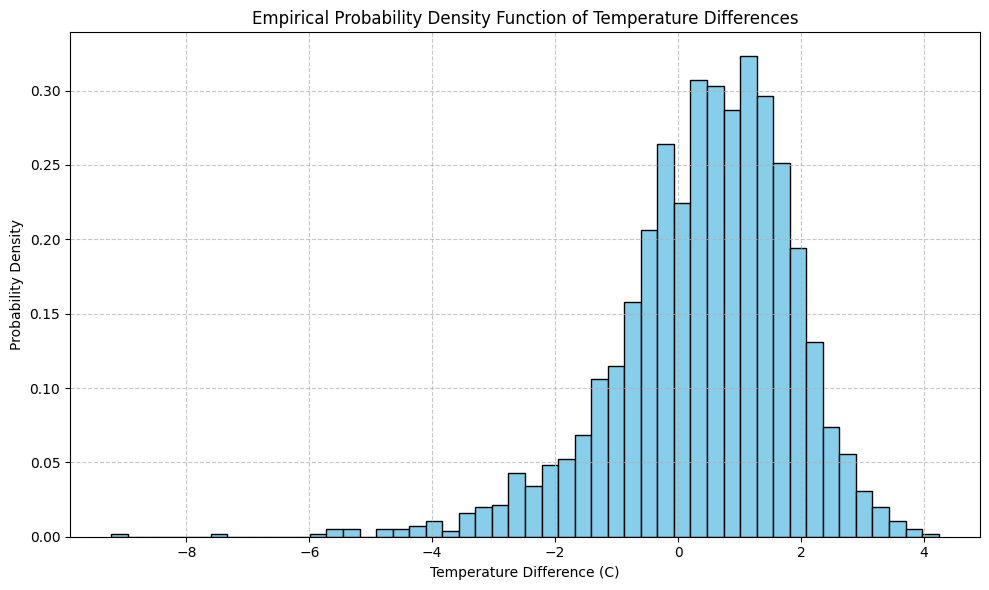

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(df_temp['diff in temp'], bins=50, color='skyblue', edgecolor='black', density=True) # Added density=True
plt.title('Empirical Probability Density Function of Temperature Differences') # Updated title
plt.xlabel('Temperature Difference (C)')
plt.ylabel('Probability Density') # Updated ylabel
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Perform Statistical Comparison (Paired t-test)

### Subtask:
Conduct a paired t-test on the 'Weather Station Temp' and 'Meteo Temp' columns to statistically assess whether the observed mean difference is significantly different from zero, providing a p-value to interpret the significance.


**Reasoning**:
To perform a paired t-test, I need to import the `ttest_rel` function from `scipy.stats` and then apply it to the 'Weather Station Temp' and 'Meteo Temp' columns of the `df_temp` DataFrame to get the t-statistic and p-value.



In [36]:
from scipy.stats import ttest_rel

# Perform a paired t-test
t_statistic, p_value = ttest_rel(df_temp['Weather Station Temp'], df_temp['Meteo Temp'])

# Print the results
print(f"Paired t-test results:\n")
print(f"T-statistic: {t_statistic:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print(f"Since the p-value ({p_value:.3f}) is less than the significance level ({alpha}), we reject the null hypothesis.")
    print("There is a statistically significant difference between the two temperature datasets.")
else:
    print(f"Since the p-value ({p_value:.3f}) is greater than the significance level ({alpha}), we fail to reject the null hypothesis.")
    print("There is no statistically significant difference between the two temperature datasets.")

Paired t-test results:

T-statistic: 13.378
P-value: 0.000
Since the p-value (0.000) is less than the significance level (0.05), we reject the null hypothesis.
There is a statistically significant difference between the two temperature datasets.
